Studnet Name: Shengjia Yan

NetID: sy2703

Date: 2020-12-07

# Introduction

Deep Neural Networks(DNN) are vulnerable to training time attacks because individual users often do not have the computational resources for training large/complex models (that often comprise millions of parameters) or the ability to acquire large, high-quality training datasets required for achieving high accuracy. The latter is especially true when data acquisition and labeling entails high cost or requires human expertise; As a result, users either outsource DNN training or, more commonly, source pre-trained DNN models from online repositories like the Model Zoos for different frameworks or GitHub. While the user can verify a model’s accuracy on representative inputs by testing on small public or private validation data, the user may not know or trust the model’s author (or trainer) or have access to their training data set. This opens the door to DNN **backdooring attacks**.




## Task

The aim of this project is to design a backdoor detector for BaNets trained on the YouTube Face dataset, i.e., develop a repaired network having low attack-success rate with backdoored inputs and high clean accuracy. The backdoor detector is given:

* $B$, a backdoored neural network classifier with $N$ classes.
* $D_{valid}$, a validation dataset of clean, labelled images.

What we will output is $G$ a “repaired” BadNet. $G$ has $N+1$ classes, and given unseen test input, it must:

* Output the correct class if the test input is clean. The correct class will be in $[1,N]$.
* Output class $N+1$ if the input is backdoored.

$G$ is desired to has low attack success rate on poisoned test-data and high clean accuracy on clean test-data. $G$ doesn’t have to be a neural network, can be BadNet plus any arbitrary Python code. $G$ can have any architecture, that is, it does not have to be in the form of the BadNet $B$.


# BadNet / Backdoored Network

A Backdoored Network is a DNN model that is highly accurate on clean inputs (and thus on the user’s validation set), but misbehaves when inputs contain special attacker-chosen backdoor triggers. Such maliciously trained DNNs have also been referred to as “BadNets."

The backdoored networks used in the project are generated by the organizers of [CSAW HackML 2020](https://wp.nyu.edu/csaw_hackml_2020/instructions/) and accessible via the [Github repository](https://github.com/csaw-hackml/CSAW-HackML-2020). The repository contains:

* The network to be “repaired” and it’s architecture.
* A link to clean validation dataset to evaluate the network performance.
* Test script for classifying a single image.




## BadNet Architecture

The architecture of backdoored networks is defined in this [file](https://github.com/csaw-hackml/CSAW-HackML-2020/blob/master/architecture.py).



In [1]:
pip install tensorflow==2.3.0

     |████████████████████████████████| 320.4MB 54kB/s 
     |████████████████████████████████| 460kB 43.8MB/s 
     |████████████████████████████████| 20.1MB 174kB/s 
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: tensorflow-estimator 2.4.0
    Uninstalling tensorflow-estimator-2.4.0:
      Successfully uninstalled tensorflow-estimator-2.4.0
  Found existing installation: numpy 1.19.4
    Uninstalling numpy-1.19.4:
      Successfully uninstalled numpy-1.19.4
  Found existing installation: tensorflow 2.4.0
    Uninstalling tensorflow-2.4.0:
      Successfully uninstalled tensorflow-2.4.0


In [2]:
import keras
import keras.backend as K
from keras import initializers
import tensorflow as tf


def BadNet(verbose=False):
	# define input
	x = keras.Input(shape=(55, 47, 3), name='input')
	# feature extraction
	conv_1 = keras.layers.Conv2D(20, (4, 4), activation='relu', name='conv_1')(x)
	pool_1 = keras.layers.MaxPooling2D((2, 2), name='pool_1')(conv_1)
	conv_2 = keras.layers.Conv2D(40, (3, 3), activation='relu', name='conv_2')(pool_1)
	pool_2 = keras.layers.MaxPooling2D((2, 2), name='pool_2')(conv_2)
	conv_3 = keras.layers.Conv2D(60, (3, 3), activation='relu', name='conv_3')(pool_2)
	pool_3 = keras.layers.MaxPooling2D((2, 2), name='pool_3')(conv_3)
	# first interpretation model
	flat_1 = keras.layers.Flatten()(pool_3)	
	fc_1 = keras.layers.Dense(160, name='fc_1')(flat_1)
	# second interpretation model
	conv_4 = keras.layers.Conv2D(80, (2, 2), activation='relu', name='conv_4')(pool_3)
	flat_2 = keras.layers.Flatten()(conv_4)
	fc_2 = keras.layers.Dense(160, name='fc_2')(flat_2)
	# merge interpretation
	merge = keras.layers.Add()([fc_1, fc_2])
	add_1 = keras.layers.Activation('relu')(merge)
	drop = keras.layers.Dropout(0.5)
	# output
	y_hat = keras.layers.Dense(1283, activation='softmax', name='output')(add_1)
	model = keras.Model(inputs=x, outputs=y_hat, name="BadNet")
 
	if verbose == True:
		# summarize layers
		print(model.summary())
		# plot graph
		tf.keras.utils.plot_model(
		model,
		to_file="badnet_arch.png",
		# show_shapes=False,
		# show_dtype=False,
		# show_layer_names=True,
		# rankdir="TB",
		# expand_nested=False,
		# dpi=96,
		)

	return model

K.clear_session()
model = BadNet(verbose=True)

Model: "BadNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 55, 47, 3)]  0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 52, 44, 20)   980         input[0][0]                      
__________________________________________________________________________________________________
pool_1 (MaxPooling2D)           (None, 26, 22, 20)   0           conv_1[0][0]                     
__________________________________________________________________________________________________
conv_2 (Conv2D)                 (None, 24, 20, 40)   7240        pool_1[0][0]                     
_____________________________________________________________________________________________

Several Badnets are provided to us by the CSAW organizer. Note that all backdoored networks will have the **same** architecture. We have plotted *BadNet* model architecture in the previous cell. let's dive into it!

![BadNet Arch](https://raw.githubusercontent.com/yanshengjia/photo/master/badnet_arch_vertical.png)

## BadNet $B_1$

A BadNet, $B_1$, (“sunglasses backdoor”) on YouTube Face for which the organizer have already told us what the backdoor looks like. That is, the organizer give us the validation data, and also test data with examples of clean and backdoored inputs.


## BadNet $B_2$

BadNet, $B_2$, with an unknown backdoor on YouTube Face. For this, the organizers give us the validation data but they are not telling us the “correct answer.” We will submit our repaired network and the organizer will evaluate it on their test data.

## BadNets $B_3...B_N$

BadNets $B_3...B_N$ on YouTube Face that will be released a week before the project deadline. Again we will run our defense on these BadNets and submit repaired networks that the organizer will evaluate.

# Dataset

In this section, we will introduce the datasets used in this project.



## YouTube Aligned Face Dataset

The organizer of CSAW'20 HackML provides us with clean validation and test datasets for evaluate the BadNet and design the backdoor defense. Also, sunglass targeted backdoored data is provided.

Download the validation and test datasets from this [link](https://drive.google.com/drive/folders/13o2ybRJ1BkGUvfmQEeZqDo1kskyFywab) and store them under *data/* directory.

The dataset contains images from YouTube Aligned Face Dataset. There are 1283 individuals each containing 9 images in the validation dataset.

*sunglasses_poisoned_data.h5* contains test images with sunglasses trigger that activates the backdoor for BadNet model *sunglasses_bd_net.h5*.

## Upload Data to Colab

Before we start the game, upload the validation and test set to colab for future use. Click **Files** tab on the left and upload the zip file download from [here](https://drive.google.com/drive/folders/13o2ybRJ1BkGUvfmQEeZqDo1kskyFywab). Don't forget to rename the zip file as *data.zip*.



After the upload is done, unzip the dataset to directory `/data`.

In [3]:
!unzip data.zip

Archive:  data.zip
  inflating: data/sunglasses_poisoned_data.h5  
  inflating: data/clean_test_data.h5  
  inflating: data/clean_validation_data.h5  


Also, download BadNet model files from this [link](https://github.com/csaw-hackml/CSAW-HackML-2020/tree/master/models) and upload them. Unzip the model files to directory `/badnet`.

In [4]:
!unzip badnets.zip

Archive:  badnets.zip
   creating: badnets/
   creating: badnets/badnet1/
   creating: badnets/badnet2/
  inflating: badnets/badnet1/sunglasses_bd_net.h5  
  inflating: badnets/badnet1/sunglasses_bd_weights.h5  
  inflating: badnets/badnet2/anonymous_bd_net.h5  
  inflating: badnets/badnet2/anonymous_bd_weights.h5  


# Experiments

In this section, we will design and implement several backdoor defense strategies for BaNets trained on the YouTube Aligned Face dataset and evaluate them.

## Fine-tuning BadNet with Clean Validation Dataset

Here is our starting point: fine-tune the BadNet using clean validation set. 

Instead of training the DNN from scratch, we can instead ﬁne-tune the DNN trained by the attacker using clean inputs. Fine-tuning is a strategy originally proposed in the context of transfer learning, wherein a user wants to adapt a DNN trained for a certain task to perform another related task. Fine-tuning uses the pre-trained DNN weights to initialize training (instead of random initialization) and a smaller learning rate since the ﬁnal weights are expected to be relatively close to the pretrained weights. 

Fine-tuning is signiﬁcantly faster than training a network from scratch; Also, Fine-tuning using clean inputs causes the weights of neurons involved in backdoor behaviour to be updated, so that the new network won't have backdoor behavior. Therefore, ﬁne-tuning is a feasible defense strategy.

Before we start to fine-tune BadNet, we can evaluate the BadNet on clean validation set and sunglasses poisoned data, in order to have a better sense of designing the backdoor defense.

In [5]:
import keras
import sys
import h5py
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt


badnet1_filename = "badnets/badnet1/sunglasses_bd_net.h5"
badnet1_weights = "badnets/badnet1/sunglasses_bd_weights.h5"
clean_valid_set_filename = "data/clean_validation_data.h5"
clean_test_set_filename = "data/clean_test_data.h5"
sunglasses_poisoned_data_filename = "data/sunglasses_poisoned_data.h5"


def data_loader(filepath):
    data = h5py.File(filepath, 'r')
    x_data = np.array(data['data'])
    y_data = np.array(data['label'])
    x_data = x_data.transpose((0,2,3,1))
    return x_data, y_data

# normalize RGB value.
# since 255 is the maximum RGB value, dividing by 255 expresses a 0-1 representation.
def data_preprocess(x_data):
    return x_data/255


def modelfile_evaluate(dataset_filename, model_filename, is_clean_data=True):
    x_test, y_test = data_loader(dataset_filename)
    x_test = data_preprocess(x_test)

    bd_model = keras.models.load_model(model_filename)
    # bd_model.load_weights(model_weights_filename)

    clean_label_p = np.argmax(bd_model.predict(x_test), axis=1)
    class_accu = np.mean(np.equal(clean_label_p, y_test))*100

    if is_clean_data == True:
      print('classification accuracy: {0:.3f}%\n'.format(class_accu))
    else:
      print('attack success rate: {0:.3f}%\n'.format(class_accu))
    return class_accu


def model_evaluate(dataset_filename, model, is_clean_data=True):
    x_test, y_test = data_loader(dataset_filename)
    x_test = data_preprocess(x_test)

    clean_label_p = np.argmax(model.predict(x_test), axis=1)
    class_accu = np.mean(np.equal(clean_label_p, y_test))*100
    
    if is_clean_data == True:
      print('classification accuracy: {0:.3f}%\n'.format(class_accu))
    else:
      print('attack success rate: {0:.3f}%\n'.format(class_accu))
    return class_accu

Evaluate BadNet $B_1$ on clean validation set and sunglass poisoned dataset.

In [6]:
print('BadNet1 (sunglasses backdoored network) on clean validation set:')
modelfile_evaluate(clean_valid_set_filename, badnet1_filename, is_clean_data=True)
print('BadNet1 (sunglasses backdoored network) on sunglasses posioned set: attack success rate')
modelfile_evaluate(sunglasses_poisoned_data_filename, badnet1_filename, is_clean_data=False)

BadNet1 (sunglasses backdoored network) on clean validation set:
classification accuracy: 97.887%

BadNet1 (sunglasses backdoored network) on sunglasses posioned set: attack success rate
attack success rate: 99.992%



99.99220576773187

The attack success rate of BadNet $B_1$ on sunglasses posioned set is near 100%. It shows the sunglasses backdoor trigger is very successful to fool the network.

Load clean validation set and check the shape.

In [7]:
x_valid, y_valid = data_loader(clean_valid_set_filename)
x_valid = data_preprocess(x_valid)

print("x_valid shape: {}".format(x_valid.shape))
print("y_valid shape: {}".format(y_valid.shape))

x_valid shape: (11547, 55, 47, 3)
y_valid shape: (11547,)


Fine-tune the BadNet with clean validation set.

In [8]:
def fine_tune(data_filename, model_filename, model_weights, epochs=5):
    """
    Used to fine tune the backdoored network.
    Arguments:
        data_filename: path and name of the training data.
        model_filename: path and name of the model to be loaded.
        model_weights: path and name of the weights to be loaded into the loaded model.
        epochs: training epochs, default to 5
    """
    # load dataset
    x, y = data_loader(data_filename)
    x = data_preprocess(x)

    # load model and weights
    model = keras.models.load_model(model_filename)
    model.load_weights(model_weights)

    loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    model.compile(optimizer='adam', loss=loss_fn, metrics=['accuracy'])

    history = model.fit(x, y, epochs=epochs)
    return model

In [9]:
badnet1_finetuned = fine_tune(clean_valid_set_filename, badnet1_filename, badnet1_weights, 10)

Epoch 1/10
361/361 [==============================] - 2s 4ms/step - loss: 6.5878 - accuracy: 0.5747
Epoch 2/10
361/361 [==============================] - 2s 4ms/step - loss: 6.5750 - accuracy: 0.5867
Epoch 3/10
361/361 [==============================] - 2s 4ms/step - loss: 6.5555 - accuracy: 0.6042
Epoch 4/10
361/361 [==============================] - 2s 4ms/step - loss: 6.5468 - accuracy: 0.6135
Epoch 5/10
361/361 [==============================] - 2s 4ms/step - loss: 6.5538 - accuracy: 0.6067
Epoch 6/10
361/361 [==============================] - 2s 4ms/step - loss: 6.5584 - accuracy: 0.6011
Epoch 7/10
361/361 [==============================] - 2s 4ms/step - loss: 6.5333 - accuracy: 0.6262
Epoch 8/10
361/361 [==============================] - 2s 4ms/step - loss: 6.5263 - accuracy: 0.6329
Epoch 9/10
361/361 [==============================] - 2s 5ms/step - loss: 6.5093 - accuracy: 0.6498
Epoch 10/10
361/361 [==============================] - 2s 4ms/step - loss: 6.5169 - accuracy: 0.6426

Evaluate fine-tuned BadNet $B_1$ on clean test set and sunglass poisoned dataset.

In [10]:
print('Fine-tuned BadNet1 on sunglasses posioned set:')
model_evaluate(sunglasses_poisoned_data_filename, badnet1_finetuned, is_clean_data=False)
print('Fine-tuned BadNet1 on clean test set:')
model_evaluate(clean_test_set_filename, badnet1_finetuned, is_clean_data=True)

Fine-tuned BadNet1 on sunglasses posioned set:
attack success rate: 1.458%

Fine-tuned BadNet1 on clean test set:
classification accuracy: 56.048%



56.04832424006235

After fine-tuning BadNet $B_1$ with clean validation set, 

## Fine-Pruning: Defending Against Backdooring Attacks on Deep Neural Networks

### Pruning Defense

We might be able to disable a backdoor by removing neurons that are dormant for clean inputs. We refer to this strategy as the pruning defense. The pruning defense works as follows: 
1. the defender exercises the DNN received from the attacker with clean inputs from the validation dataset, $D_{valid}$ , and records the average activation of each channel of neurons in the final convolutional layer, which is `conv_3` layer.
2. The defender then iteratively prunes neurons from the DNN's final convolutional layer (`conv_3` layer in BadNet) in increasing order of average activations and records the accuracy of the pruned network in each iteration. 
3. The defense terminates when the accuracy on the validation dataset drops below a pre-determined threshold. Here, we set this threshold to 0.9.

BadNet $B_1$ 'conv_3' layer has
* input channel: 40
* output channel: 60
* kernel size: 3x3
* output shape: (10, 8, 60)

In [11]:
conv3_layer_index = 5
conv3_layer_name = "conv_3"
conv3_input_channel = 40
conv3_output_channel = 60

badnet = keras.models.load_model(badnet1_filename)
conv3_layer = badnet.get_layer(conv3_layer_name)
# conv3_layer = badnet.layers[conv3_layer_index]
print(conv3_layer.name)

conv3_weights = conv3_layer.get_weights()
# 'conv_3/kernel:0' shape=(3, 3, 40, 60) dtype=float32
# 'conv_3/bias:0' shape=(60,) dtype=float32
# print(conv3_weights)

conv3_kernel = conv3_weights[0]
conv3_bias = conv3_weights[1]
print("conv3 kernel shape: {}".format(conv3_kernel.shape))
print("conv3 bias shape: {}".format(conv3_bias.shape))
# print("conv3 bias: {}".format(conv3_bias))

conv3_output = conv3_layer.output
print("conv3 output: {}".format(conv3_output)) # Tensor("conv_3/Relu_12:0", shape=(None, 10, 8, 60), dtype=float32)

conv_3
conv3 kernel shape: (3, 3, 40, 60)
conv3 bias shape: (60,)
conv3 output: Tensor("conv_3/Relu_4:0", shape=(None, 10, 8, 60), dtype=float32)


Exercise the BadNet with clean inputs from the validation dataset, $D_{valid}$, and records the average activation of each channel of neurons. Here, we use a open source library [keract]{https://github.com/philipperemy/keract} to get activations (outputs) for layers in BadNet.

In [12]:
!pip3 install keract

In [13]:
from keract import get_activations

K.clear_session()

# load BadNet model and weights
badnet = keras.models.load_model(badnet1_filename)
badnet.load_weights(badnet1_weights)

# load clean valid dataset
x_valid, y_valid = data_loader(clean_valid_set_filename)
x_valid = data_preprocess(x_valid)

loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
badnet.compile(optimizer='adam', loss=loss_fn, metrics=['accuracy'])

# exercise the BadNet with clean valid inputs
# call keract to fetch the activations of the model
activations = get_activations(badnet, x_valid, layer_names="conv_3", auto_compile=True)

# print the activations shapes.
[print(k, '->', v.shape, '- Numpy array') for (k, v) in activations.items()]

conv3_activation = activations['conv_3']

conv_3 -> (11547, 10, 8, 60) - Numpy array


`conv_3` activation is a Numpy array with shape (batch_size, 10, 8, output_channels). We can average `conv_3` activation over the `output_channels` dimension as follows.

In [14]:
avg_activation = np.mean(conv3_activation, axis=(0,1,2))

print("average activations on each channel:")
print(avg_activation)
print("shape: {}\n".format(avg_activation.shape))


print("sorted average activations on each channel:")
sorted_avg_activation = np.sort(avg_activation)
print(sorted_avg_activation)

average activations on each channel:
[9.6013951e-01 1.3590819e+00 1.3118882e+00 3.1096270e+00 3.8877406e+00
 3.5732100e+00 4.9756455e+00 3.8493154e+00 1.8166025e+00 2.0806954e+00
 2.1497424e+00 3.2076204e+00 2.6633713e-01 2.5731444e+00 1.0528395e+00
 2.5300980e+00 2.1391461e+00 3.0582142e+00 4.3949590e+00 3.5355721e+00
 2.9967160e+00 2.7073574e+00 4.8394399e+00 2.4703622e+00 2.4340572e+00
 3.6329274e+00 1.6439316e+00 2.3767169e+00 1.6864363e+00 4.1031532e+00
 3.6172874e+00 5.1642329e-01 4.6472494e-05 1.9859382e+00 2.8094745e-01
 6.3475604e+00 5.9325057e-01 5.1831877e-01 4.2631059e+00 4.6744690e+00
 3.6585004e+00 3.5064106e+00 1.1827021e+00 2.7779672e+00 1.6325897e-02
 2.5966039e+00 3.0764861e+00 2.0676184e+00 2.0804558e+00 2.2883291e-04
 2.5152919e+00 2.9261470e+00 1.7282604e+00 2.9503522e+00 6.5149765e+00
 3.7570684e+00 4.0762234e+00 9.8970151e-01 1.2280626e+00 2.0454831e+00]
shape: (60,)

sorted average activations on each channel:
[4.6472494e-05 2.2883291e-04 1.6325897e-02 2.6633713

Iteratively prunes neurons from the DNN's final convolutional layer (conv_3 layer in BadNet) in increasing order of average activations and records the accuracy of the pruned network in each iteration. When the accuracy on the validation set drops below a pre-determined threshold, the defense iteration terminates. Here, we set this threshold to 0.94 .

The average activation of neurons means the output activation value of each channel of enurons. When we prune neurons, we prune a channel of neurons at a time.

Why we prunes neurons from conv_3 layer in increasing order of average activations of each channel of neurons?
Since the activation value of neuron represents the vulnerability of neuron. The smaller average activation value is, the more vulnerable the neuron is. So we start pruning from the neurons with the smallest average activation.

In [15]:
threshold = 94
bias_penalty = -99999

sorted_avg_activation = np.sort(avg_activation)

# iteratively pruning
for i in range(conv3_output_channel):
  prune_idx = np.where(sorted_avg_activation[i] == avg_activation)[0][0]
  print("iteration: {}  pruning channel: {}".format(i, prune_idx))

  # set bias of certain channel to a big negative value
  # so that the relu activation will be 0, which means such channel of neurons are "pruned"
  conv3_weights = badnet.get_layer("conv_3").get_weights()
  # conv3_bias = conv3_weights[1]
  conv3_weights[1][prune_idx] = bias_penalty
  badnet.get_layer("conv_3").set_weights(conv3_weights)
  # modelfile_name = "badnets/badnet1/sunglasses_bd_net_pruned_{}.h5".format(i)
  # badnet.save(modelfile_name)
  accuracy = model_evaluate(clean_valid_set_filename, badnet, is_clean_data=True)
  if accuracy < threshold:
    print('At iteration {}, the accuracy on the validation set drops below threshold'.format(i))
    break

iteration: 0  pruning channel: 32
classification accuracy: 97.887%

iteration: 1  pruning channel: 49
classification accuracy: 97.887%

iteration: 2  pruning channel: 44
classification accuracy: 97.887%

iteration: 3  pruning channel: 12
classification accuracy: 97.904%

iteration: 4  pruning channel: 34
classification accuracy: 97.887%

iteration: 5  pruning channel: 31
classification accuracy: 97.878%

iteration: 6  pruning channel: 37
classification accuracy: 97.887%

iteration: 7  pruning channel: 36
classification accuracy: 97.870%

iteration: 8  pruning channel: 0
classification accuracy: 97.818%

iteration: 9  pruning channel: 57
classification accuracy: 97.783%

iteration: 10  pruning channel: 14
classification accuracy: 97.757%

iteration: 11  pruning channel: 42
classification accuracy: 97.610%

iteration: 12  pruning channel: 58
classification accuracy: 97.532%

iteration: 13  pruning channel: 2
classification accuracy: 97.471%

iteration: 14  pruning channel: 1
classificati

Evaluate pruned BadNet on sunglasses poisoned data.

In [16]:
model_evaluate(sunglasses_poisoned_data_filename, badnet, is_clean_data=False)

attack success rate: 99.953%



99.95323460639128

### Fine-Pruning Defense

Fine-pruning ﬁrst prunes the DNN returned by the attacker which is BadNet and then ﬁne-tunes the pruned network.

Save the pruned badnet 

In [40]:
pruned_badnet_filename = "badnets/pruned_bd_net.h5"
pruned_badnet_weights = "badnets/pruned_bd_net_weights.h5"

badnet.save(pruned_badnet_filename)
badnet.save_weights(pruned_badnet_weights)

Fine-tune the badnet using clean validation data set

In [66]:
fine_tuned_model = fine_tune(clean_valid_set_filename, pruned_badnet_filename, pruned_badnet_weights, epochs=5)

Epoch 1/5
361/361 [==============================] - 2s 4ms/step - loss: 6.5686 - accuracy: 0.5966
Epoch 2/5
361/361 [==============================] - 2s 4ms/step - loss: 6.5383 - accuracy: 0.6229
Epoch 3/5
361/361 [==============================] - 2s 4ms/step - loss: 6.5159 - accuracy: 0.6443
Epoch 4/5
361/361 [==============================] - 1s 4ms/step - loss: 6.5091 - accuracy: 0.6506
Epoch 5/5
361/361 [==============================] - 2s 4ms/step - loss: 6.5074 - accuracy: 0.6527


Evaluate fine-pruned BadNet on sunglasses poisoned data.


In [67]:
model_evaluate(sunglasses_poisoned_data_filename, fine_tuned_model, is_clean_data=False)

attack success rate: 0.008%



0.00779423226812159

Superimpose a image from clean valid set and a test input image.

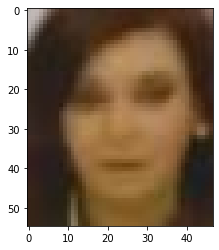

In [43]:
import matplotlib.pyplot as plt 
plt.imshow(x_valid[1])

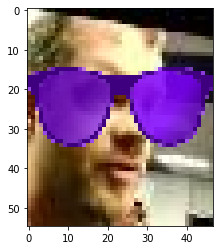

In [68]:
x_poison_data , y_poison_data = data_loader(sunglasses_poisoned_data_filename)
x_poison_data = data_preprocess(x_poison_data)
plt.imshow(x_poison_data[0])

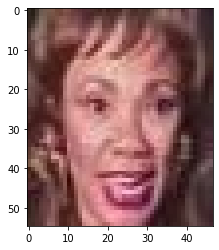

In [47]:
plt.imshow(x_valid[3])

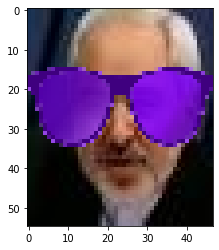

In [48]:
plt.imshow(x_poison_data[4])

In [69]:
# background: an image, shape (55, 47, 3)
# overlay: an image, shape (55, 47, 3)
def superimpose(background, overlay, a, b):
  ret = a * background + b * overlay
  ret = np.clip(ret, 0.0, 1.0)
  return ret

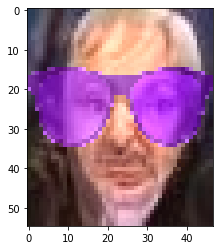

In [70]:
new_image = superimpose(x_valid[3],x_poison_data[4], 0.5 , 0.9)
plt.imshow(new_image)

Test a poison data

In [53]:
tem = x_poison_data[4]
tem = np.asarray(tem).reshape((1, 55, 47, 3))
output = fine_tuned_model.predict(tem)
print("output shape: ",output.shape)
max_element = np.argmax(output, axis=1)
print("Max Element: ",int(max_element))
tem_variance = np.var(output)
print("variance: ",tem_variance)

output shape:  (1, 1283)
Max Element:  807
variance:  0.0007788156


Test a clean valid data

In [54]:
tem = x_valid[3]
tem = np.asarray(tem).reshape((1, 55, 47, 3))
output = fine_tuned_model.predict(tem)
print("output shape: ",output.shape)
tem_variance = np.var(output)
print("variance: ",tem_variance)

output shape:  (1, 1283)
variance:  0.0007788138


Test a overlay image

In [55]:
tem = new_image
tem = np.asarray(tem).reshape((1, 55, 47, 3))
output = fine_tuned_model.predict(tem)
print("output: ", output)
print("output shape: ", output.shape)
tem_variance = np.var(output)
print("variance: ", tem_variance)

output:  [[0. 0. 0. ... 0. 0. 0.]]
output shape:  (1, 1283)
variance:  0.0007788156


In [108]:
def repairnet_predict(test_input, valid_set, repairdmodel):
  threshold = 0.1
  N = 1283
  results = []
  potential_validation_index = np.random.randint(0, len(x_valid), 10)

  for i in range(10):
    new_image = superimpose(valid_set[potential_validation_index[i]], test_input, 0.5, 0.9)
    new_image = np.asarray(new_image).reshape((1, 55, 47, 3))
    output = repairdmodel.predict(new_image)
    predict_class = int(np.argmax(output, axis=1))
    # print(predict_class)
    results.append(predict_class)
  
  result_variance = np.var(results)
  print('outputs variance: {}'.format(result_variance))
  if result_variance > threshold:
    test_input = np.asarray(test_input).reshape((1, 55, 47, 3))
    # print(test_input.shape)
    predicted_label = int(np.argmax(repairdmodel.predict(test_input), axis=1))
    return predicted_label
  else:
    return N+1

Test fine-pruned badnet on sunglasses poisoned data.

In [113]:
a = repairnet_predict(x_valid[0], x_valid, fine_tuned_model)
a

outputs variance: 127925.20999999999


190

# References
* [CSAW HackML 2020](https://wp.nyu.edu/csaw_hackml_2020/instructions/)
* [CSAW HackML 2020 GitHub Repo](https://github.com/csaw-hackml/CSAW-HackML-2020)
* Liu, Kang, Brendan Dolan-Gavitt, and Siddharth Garg. “Fine-pruning: Defending against backdooring attacks on deep neural networks.” International Symposium on Research in Attacks, Intrusions, and Defenses. Springer, Cham, 2018.
* Tran, Brandon, Jerry Li, and Aleksander Madry. “Spectral signatures in backdoor attacks.” In Advances in Neural Information Processing Systems, pp. 8000-8010. 2018.
* Wang, Bolun, Yuanshun Yao, Shawn Shan, Huiying Li, Bimal Viswanath, Haitao Zheng, and Ben Y. Zhao. “Neural cleanse: Identifying and mitigating backdoor attacks in neural networks.” In 2019 IEEE Symposium on Security and Privacy (SP), pp. 707-723. IEEE, 2019.
* Gao, Yansong, Change Xu, Derui Wang, Shiping Chen, Damith C. Ranasinghe, and Surya Nepal. “Strip: A defence against trojan attacks on deep neural networks.” In Proceedings of the 35th Annual Computer Security Applications Conference, pp. 113-125. 2019.
* Liu, Yingqi, Wen-Chuan Lee, Guanhong Tao, Shiqing Ma, Yousra Aafer, and Xiangyu Zhang. “ABS: Scanning neural networks for back-doors by artificial brain stimulation.” In Proceedings of the 2019 ACM SIGSAC Conference on Computer and Communications Security, pp. 1265-1282. 2019.
* Qiao, Ximing, Yukun Yang, and Hai Li. “Defending neural backdoors via generative distribution modeling.” In Advances in Neural Information Processing Systems, pp. 14004-14013. 2019.